![wildfire](./prescribed_burn_public_domain.jpg)

# Predicting Wildfire Smoke Composition

Prof. Jen is a world-expert at understanding the composition and wildfire smokes. In 2017, she was part of an experimental campaign to map the composition of smokes for controlled wildfire burns for several specific plots of forest at the Blodgett Forest Research Station in Georgetown, CA. 

Prof. Jen and her collaborators exposed filters to the burns at either ground level or at elevation using remote-controlled drones (each drone had three filters). They then took those filters and used a special analytic technique (GCxGC/MS, which you probably learned about in analytical chem) to identify unique spectral signatures of compounds present in the filters. In a few cases they know the compounds that generate specific signatures, but in many cases it's unclear exactly which compound led to a specific GCxGC/MS signature. 

`````{note}
**Wildfire dataset summary:**
* 3 different plots of land (with labels 60, 340, 400) were burned. One unburned plot was also included as a control (0).
* Each plot was sampled multiple times at varying times. 
    * Plots were sampled at the ground level in triplicate (3 filters)
    * Plots were sampled with drones at elevation in triplicate (3 filters)
* All filters were collected and analyzed with GCxGC/MS. The unique ID of blobs present and the associated concentration on the filter were recorded. 
* The prevalent plants and foliage present in each plot is also known based on a previous survey of the regions. 
`````

`````{seealso}
You can read more about how one of Prof. Jen's collaborators analyzed this data [here](https://www.climatechange.ai/papers/neurips2020/82). That same site includes both a paper and a short video by a collaborator on the specific analysis tried.
`````

## Suggested challenges

* Given a filter and a set of observed blobs, predict whether that filter was exposed at ground level or at elevation (with a drone)
* Given the filter of a filter at elevation (drone, easy to collect data), predict the blobs and their concentrations for the ground level measurements (harder to collect data)
* [much harder] Given the filter and a set of observed blobs, predict the types of plants present in the plot of land

````{note}
In each case, you should think critically about the question how you want to set up your train/validation/test splits to simulate the challenge. 
* What do you expect to be correlated?
* How would you know if your model is helpful?
* Is there any way to cheat at the task? 
````

## Dataset download/availability instructions
https://github.com/ulissigroup/F22-06-325/tree/main/f22-06-325/projects/wildfires/data

## Dataset/file format details
1. BlodgettCombinedBlobMass.csv is a spreadsheet that gives the electron ionization mass spectrum for each compound detected during the Blodgett field campaign. 
    * The mass spectrum (each element) is written as mass, signal; mass, signal; etc.
    * The row number corresponds to the compound of the same row number found in BlodgettCombinedBlobTable.csv
2. BlodgettCombinedBlobTable.cvs contains all compound 2 dimension gas chromatography data from all samples collected from Blodgett 2017. The column headings are:
    1. Unused tag
    2. BlobID_1
    3. Unused Tag
    4. 1D retention time (min)
    5. 2D retention time (sec)
    6. Peak height
    7. Peak volume
    8. Peak volume divided by nearest internal standard peak volume
    9. Calculated d-alkane retention index
    10. matched retention index (this number should be super close to the retention index in column 9)
    11. Unused tag
    12. Unused tag
    13. Unused tag
    14. BlobID_2
    15. Filter number. This is the filter number that can be linked to where and when the sample was collected
    16. Unused tag
    17. Mass concentration of this compound (ng/m3)
    * BlobID_1 and BlobID_2 (column 2 and 14) define the unique ID of a blob that can be tracked across the different burns. In other words, a compound (blob) with an ID of 1,176 is the same compound in filter 201 and filter 202. 
    * The d-alkane retention index (column 10) and 2nd dimension retention time (column 5) define the unique x,y position the compound sits in the chromatogram. No two compounds will have the same x,y coordinate. 
    * Mass concentration defines the amount of compound that exists in the smoke. 
3. Run Log.xlsx details where each filter was collected in Blodgett by GPS location and forest plot that burned. Tab “Flight Log” provides the details of filters collected from the drone. Tab “ground Station” provides details of filters collected at ground level.
4. All_Shrubcovony_01_16.xlsx displays the types of shrubs that grew at Blodgett. The sheet of interest is “16” which stands for 2016 when they conducted a plant inventory. Focus on Unit (1st column) 60, 340, and 400 which stand for the plots that we burned at Blodgett. Species column lists the shorthand for the shrub/grass that they observed growing in the plot. BFRSPlantCodes.xlsx translate the shorthand plant code to a real plant.
5. `2017 rx burning_topos.pdf` and `BFRSWallMap2017.pdf` Pictures of the units burned.
6. `Filters vs forest plot number.xlsx`: A more explicit listing of which forest unit each filter was collected at.

## Hints and possible approaches

## Example Model

### Loading in Data
Let's start by uploading the data. We'll start with BlodgettCombinedBlobTable.csv. 

#### BlodgettCombinedBlobTable.csv

In [1]:
import pandas as pd

# define column names
col_names = ["Unused tags 1", "BlobID1", "Unused tags 2", 
            "1D Retention Time (min)", "2D Retention Time (sec)", 
            "Peak Height", "Peak Volume", "Peak volume/nearest internal standard peak volume", 
            "Calculated d-alkane retention index", "matched retention index", 
            "Unused tags 3", "Unused tags 4", "Unused tags 5", 
            "BlobID_2", "Filter number", "Unused tags 6", 
            "Mass concentration of compound (ng/m3)"]

# import csv file
df_blobtable = pd.read_csv("data/BlodgettCombinedBlobTable.csv", names=col_names)

df_blobtable

,Unused tags 1,BlobID1,Unused tags 2,1D Retention Time (min),2D Retention Time (sec),Peak Height,Peak Volume,Peak volume/nearest internal standard peak volume,Calculated d-alkane retention index,matched retention index,Unused tags 3,Unused tags 4,Unused tags 5,BlobID_2,Filter number,Unused tags 6,Mass concentration of compound (ng/m3)
0,541,181,541,40.608204,1.026330,105.022469,1263.347317,1.000000,1652.439024,1653.0,866,868,39,0,201,0.000000,0.000000
1,598,1553,598,40.037744,1.414941,31.052483,479.394947,1.000000,1634.146341,1633.0,775,782,32,0,201,0.000000,0.000000
2,766,62,766,63.502673,1.135938,8.124082,135.140907,1.000000,2524.561404,2520.0,871,877,35,0,201,0.000000,0.000000
3,530,776,530,27.259436,1.355154,281.546460,3376.619472,1.000000,1263.387978,1277.0,842,883,40,0,201,0.000000,0.000000
4,540,61,540,32.013271,0.328824,118.679093,946.665804,1.000000,1400.000000,1800.0,0,830,20,0,201,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,970,2811,522,40.312724,0.981316,4.096229,57.013969,0.019236,1644.171779,1646.0,713,755,6,176,9,0.022829,0.783983
44636,529,2812,522,40.274506,1.131518,155.203347,1839.028248,0.620461,1642.944785,1642.0,837,845,824,176,9,4.682465,160.803335
44637,524,2813,522,40.045199,0.891195,201.872901,2958.995344,0.998322,1635.582822,1637.0,883,885,8,176,9,0.712658,24.473803
44638,783,2818,530,45.892543,0.931249,6.134070,124.792845,0.043840,1825.675676,1824.0,681,689,722,176,9,0.038751,1.330786


We can remove all of the columns with the unused tags and drop the NaN's.

In [2]:
unusedtags = ["Unused tags 1", "Unused tags 2", "Unused tags 3", 
                "Unused tags 4", "Unused tags 5", "Unused tags 6"]

#import numpy as np 

#df_blobtable.replace(np.inf, np.nan, inplace=True)

pd.set_option('use_inf_as_na',True)

df_blobtable = df_blobtable.drop(labels=unusedtags, axis=1)
df_blobtable = df_blobtable.dropna()

In [3]:
df_blobtable

,BlobID1,1D Retention Time (min),2D Retention Time (sec),Peak Height,Peak Volume,Peak volume/nearest internal standard peak volume,Calculated d-alkane retention index,matched retention index,BlobID_2,Filter number,Mass concentration of compound (ng/m3)
0,181,40.608204,1.026330,105.022469,1263.347317,1.000000,1652.439024,1653.0,0,201,0.000000
1,1553,40.037744,1.414941,31.052483,479.394947,1.000000,1634.146341,1633.0,0,201,0.000000
2,62,63.502673,1.135938,8.124082,135.140907,1.000000,2524.561404,2520.0,0,201,0.000000
3,776,27.259436,1.355154,281.546460,3376.619472,1.000000,1263.387978,1277.0,0,201,0.000000
4,61,32.013271,0.328824,118.679093,946.665804,1.000000,1400.000000,1800.0,0,201,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
44635,2811,40.312724,0.981316,4.096229,57.013969,0.019236,1644.171779,1646.0,176,9,0.783983
44636,2812,40.274506,1.131518,155.203347,1839.028248,0.620461,1642.944785,1642.0,176,9,160.803335
44637,2813,40.045199,0.891195,201.872901,2958.995344,0.998322,1635.582822,1637.0,176,9,24.473803
44638,2818,45.892543,0.931249,6.134070,124.792845,0.043840,1825.675676,1824.0,176,9,1.330786


#### All_ShrubCovOnly_01_16.xlsx

We can also load in the data from All_ShrubCovOnly_01_16.xlsx to get information about what plants are present at certain sites.

In [4]:
df_shrub = pd.read_excel("data/All_ShrubCovOnly_01_16.xlsx", sheet_name="16")

df_shrub

,Unit,Plot,StandID,Year,Species,Stature,Pcover,Aveht,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,40,2,402,2016,LIDE,Tall,2,6.0,NaN,Sum of Pcover,Column Labels,NaN
1,40,3,403,2016,LIDE,Tall,4,3.0,NaN,Row Labels,Short,Tall
2,40,3,403,2016,SYMO,Short,2,0.5,NaN,18010,2,35
3,40,7,407,2016,LIDE,Tall,8,4.0,NaN,180101,4,90
4,40,12,4012,2016,LIDE,Tall,30,3.0,NaN,180102,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...
771,590,117,590117,2016,ROGY,Short,2,0.5,NaN,NaN,NaN,NaN
772,590,118,590118,2016,ARPA,Tall,2,1.5,NaN,NaN,NaN,NaN
773,590,118,590118,2016,CEIN,Tall,10,5.0,NaN,NaN,NaN,NaN
774,590,118,590118,2016,CHFO,Short,2,0.0,NaN,NaN,NaN,NaN


#### BFRSPlantCodes.xlsx

Now the data from BFRSPlantCodes.xlsx is read in to get information that links the shorthand code name to the real plant name.

In [5]:
df_plantnames = pd.read_excel("data/BFRSPlantCodes.xlsx")

df_plantnames

,Sp-Code,Name,Common,Family,Sp-Notes,BFRSCode
0,GAL-1,Galium,Bedstraw,Rubiaceae,??????????????,NaN
1,CRUCIF,Brassicaceae (Cruciferae),Mustard Family,Brassicaceae (Cruciferae),NaN,NaN
2,CHGR-1,Cheilanthes gracillima,NaN,Pteridaceae (fern),NaN,NaN
3,STLE-1,Achnatherum lemmonii (Stipa l.),NaN,Poaceae (Gramineae)(Stipeae),"Name change, Jepson '93.",ACLE (STLE)
4,ACMA,Acer macrophyllum,Bigleaf Maple,Aceraceae,NaN,ACMA
...,...,...,...,...,...,...
332,VIO-1,Viola spp.,Violet,Violaceae,NaN,VIO-
333,VIOLAC,Violaceae,Violet Family,Violaceae,NaN,VIOZ
334,VIPU,Viola purpurea (some subspecies = new species),NaN,Violaceae,Several new species described from this specie...,VIPU
335,WHDE,Whitneya dealbata,NaN,Asteraceae (Compositae),NaN,WHDE


#### Run_Log.xlsx

We can also load in the data from Run_Log.xlsx for data collected during the flight and ground collections.

In [6]:
df_filter_flight = pd.read_excel("data/Run_Log.xlsx", sheet_name="Flight Log")

df_filter_flight

,Date,Plot Number,Flight #,Pump on,take off time,In Plume,Out of plume,Land time,Pump off,Filter #,...,Unnamed: 17,flight display times,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,2017-10-30 00:00:00,340.0,1.0,11:54:00,11:55:00,NaN,NaN,NaN,12:13:00,A1,...,340.0,1.0,11:57:00,12:16:00,A1,B1,P1,50.0,NaN,1900-01-03 11:57:00
1,2017-10-30 00:00:00,340.0,2.0,12:59:00,13:00:00,13:03:00,13:14:00,NaN,13:16:00,A2,...,340.0,2.0,13:02:00,13:19:00,A2,B2,P2,53.0,NaN,NaT
2,2017-10-30 00:00:00,340.0,3.0,16:50:00,NaN,NaN,17:03:00,NaN,17:05:00,A3,...,340.0,3.0,16:58:00,17:12:00,A3,B3,P3,41.0,NaN,NaT
3,2017-10-30 00:00:00,340.0,4.0,18:08:00,NaN,18:10:00,18:22:00,NaN,18:24:00,A4,...,340.0,4.0,18:23:00,18:39:00,A4,B4,P4,14.0,NaN,NaT
4,2017-10-31 00:00:00,60.0,5.0,11:32:00,NaN,11:35:00,11:49:00,NaN,11:51:00,A5,...,60.0,5.0,11:32:00,11:51:00,A5,B5,P5,50.0,NaN,NaT
5,2017-10-31 00:00:00,60.0,6.0,12:10:00,NaN,12:11:00,12:24:00,NaN,12:25:00,A6,...,60.0,6.0,12:10:00,12:25:00,A6,B6,P6,40.0,NaN,NaT
6,2017-10-31 00:00:00,60.0,7.0,12:45:00,NaN,12:45:00,12:55:00,NaN,12:58:00,A7,...,60.0,7.0,12:45:00,12:58:00,A7,B7,P7,32.0,NaN,NaT
7,2017-10-31 00:00:00,60.0,8.0,13:25:00,NaN,13:25:00,NaN,NaN,13:35:00,A8,...,60.0,8.0,13:25:00,13:35:00,A8,B8,P8,35.0,NaN,NaT
8,2017-10-31 00:00:00,0.0,9.0,15:12:00,15:15:00,NaN,NaN,15:25:00,15:28:00,A9,...,0.0,9.0,15:12:00,15:28:00,A9,B9,P9,50.0,NaN,NaT
9,2017-10-31 00:00:00,60.0,10.0,16:06:00,16:08:00,NaN,NaN,16:29:00,16:30:00,A10,...,60.0,10.0,16:06:00,16:30:00,A10,B10,P10,20.0,NaN,NaT


In [7]:
df_filter_ground = pd.read_excel("data/Run_Log.xlsx", sheet_name="Ground Station")

df_filter_ground

,start date,Start time,Date end,End Time,Combined Start,Combined End,Channel #,Flow Rate (P),Flow Rate (G),Fliter (F),Tube
0,2017-10-30 00:00:00,12:33:40,2017-10-30,13:33:40,2017-10-30 12:33:40,2017-10-30 13:33:40,1.0,20.19,0.277,201.0,1101096.0
1,2017-10-30 00:00:00,13:35:00,2017-10-30,14:35:00,2017-10-30 13:35:00,2017-10-30 14:35:00,2.0,20.17,0.268,202.0,1100926.0
2,2017-10-30 00:00:00,14:36:44,2017-10-30,15:36:44,2017-10-30 14:36:44,2017-10-30 15:36:44,3.0,20.69,0.277,203.0,1101437.0
3,2017-10-30 00:00:00,16:41:16,2017-10-30,17:44:00,2017-10-30 16:41:16,2017-10-30 17:44:00,4.0,19.93,0.265,204.0,1100936.0
4,2017-10-30 00:00:00,17:45:00,2017-10-30,18:38:00,2017-10-30 17:45:00,2017-10-30 18:38:00,5.0,20.25,0.258,205.0,1048717.0
5,2017-10-30 00:00:00,19:45:00,2017-10-30,20:15:00,2017-10-30 19:45:00,2017-10-30 20:15:00,1.0,20.19,0.277,207.0,1048371.0
6,2017-10-30 00:00:00,20:15:00,2017-10-30,20:45:00,2017-10-30 20:15:00,2017-10-30 20:45:00,2.0,20.17,0.268,208.0,1101043.0
7,2017-10-30 00:00:00,20:45:00,2017-10-30,21:15:00,2017-10-30 20:45:00,2017-10-30 21:15:00,3.0,20.69,0.258,209.0,1101022.0
8,2017-10-30 00:00:00,21:15:00,2017-10-30,21:45:00,2017-10-30 21:15:00,2017-10-30 21:45:00,4.0,19.93,0.265,210.0,1079817.0
9,2017-10-30 00:00:00,21:45:00,2017-10-30,22:15:00,2017-10-30 21:45:00,2017-10-30 22:15:00,5.0,20.25,0.258,211.0,1101103.0


### Predicting Mass Concentration from BloblID

Now that some of the data has been read in, we can start to make our model. For this simple example model, we will try and predict a correlation between the BlobID, or the compound, and the amount of that compound in the smoke, given by the mass concentration. We will use RandomForestRegressor as part of sklearn. 

We start with splittig our data into a train/test split.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_blobtable["BlobID1"], df_blobtable["Mass concentration of compound (ng/m3)"])

We will now fit the correlation between the BlobID and mass flow of that compound in the smoke. We will then test it on the test data.

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train.values.reshape(-1, 1), Y_train.values.reshape(-1, 1))

/tmp/ipykernel_559/1210977809.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train.values.reshape(-1, 1), Y_train.values.reshape(-1, 1))


RandomForestRegressor()

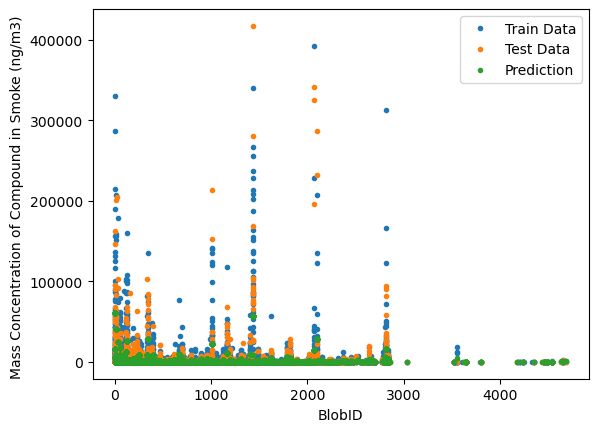

In [10]:
import matplotlib.pyplot as plt 

plt.plot(X_train.values.reshape(-1, 1), Y_train.values.reshape(-1, 1), '.')
plt.plot(X_test.values.reshape(-1, 1), Y_test.values.reshape(-1, 1), '.')
plt.plot(X_test.values.reshape(-1, 1), model.predict(X_test.values.reshape(-1, 1)), '.')
plt.xlabel('BlobID')
plt.ylabel('Mass Concentration of Compound in Smoke (ng/m3) ')
plt.legend(['Train Data', 'Test Data', 'Prediction']);

This model is not too conclusive about the mass concentration of the compound based on it's BlobID. This could be due to the data being collected at multiple plots and both measured on the ground and in the air. To improve upon this, you can try and see if there is a correlation between the mass concentration of a compound at a certain plot, or the elevation during a burn. 

There are also several other paths you can take for your project. However, this simple model does show how you can load in the data and start to use it.